<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Ejercicios%20TAM_2025-1/Segmentacion_Imagenes_Clustering_PCA_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de Imágenes con Clustering No Supervisado

Este notebook implementa y compara métodos de clustering para la segmentación de imágenes en color, integrando información espacial y técnicas de reducción de dimensionalidad. Se hace uso de la librería **RAPIDS** (`cuML`) para aprovechar aceleración por GPU, si está disponible.


In [1]:
# Instalación del entorno RAPIDS (si aún no está instalado)

# Esta celda reiniciará el entorno, solo se debe ejecutar una vez.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils/colab
!python rapids-colab.py stable

# El entorno se reiniciará automáticamente tras ejecutar esta celda.


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 3.90 MiB/s, done.
Resolving deltas: 100% (299/299), done.
/content/rapidsai-csp-utils/colab
python3: can't open file '/content/rapidsai-csp-utils/colab/rapids-colab.py': [Errno 2] No such file or directory


In [4]:
!pip install gdown


In [5]:
# Verificación que RAPIDS está correctamente instalado
try:
    import cuml
    from cuml.cluster import KMeans as cuKMeans
    RAPIDS_AVAILABLE = True
    print("RAPIDS (cuML) está disponible.")
except ImportError:
    RAPIDS_AVAILABLE = False
    print("RAPIDS no está disponible. Se usará scikit-learn como alternativa.")


RAPIDS (cuML) está disponible.


## Carga y preprocesamiento de la imagen

Se carga una imagen a color y se transforma en una matriz de datos donde cada píxel se representa por sus valores RGB y su ubicación espacial (x, y). Esto permite aplicar clustering considerando tanto el color como la posición del píxel en la imagen.


In [6]:
# Descarga de la imagen tanjiro.jpeg desde Google Drive
FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!gdown --id $FILEID --output tanjiro.jpeg


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP
To: /content/tanjiro.jpeg
100% 6.48k/6.48k [00:00<00:00, 24.0MB/s]


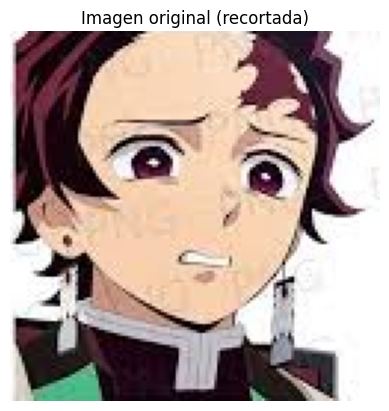

Dimensiones de imagen: 125 x 125 x 3


In [7]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

# Cargar imagen desde la ruta correcta
image = imread("tanjiro.jpeg")

# Recorte opcional (para reducir tamaño)
image = image[50:175, 50:175, :]

# Mostrar imagen
plt.imshow(image)
plt.title("Imagen original (recortada)")
plt.axis("off")
plt.show()

# Guardar dimensiones
rows, cols, channels = image.shape
print(f"Dimensiones de imagen: {rows} x {cols} x {channels}")


In [8]:
# Construcción de la matriz de datos con color y posición

# Aplanar la imagen en color: (n_pixeles, 3)
X_rgb = image.reshape(-1, 3)

# Crear coordenadas espaciales: (n_pixeles, 2)
X_coords = np.indices((rows, cols)).transpose(1, 2, 0).reshape(-1, 2)

# Unir color + posición
X_full = np.hstack((X_rgb, X_coords))

print("Forma final de la matriz:", X_full.shape)


Forma final de la matriz: (15625, 5)


## Clustering sobre datos [RGB + posición]

Aqui se aplica el algoritmo **KMeans** utilizando RAPIDS (`cuML`) para segmentar la imagen con base en el color y la ubicación espacial de cada píxel. Se evalúa la calidad del clustering utilizando **inercia** e **índice de silueta**, y se visualiza la segmentación para diferentes valores de clusters: $k \in \{3, 5, 7, 9\}$.


In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as skKMeans
import numpy as np

def segment_image_with_kmeans(X, k, use_rapids=True):
    """Aplica KMeans (cuML o sklearn) y retorna etiquetas, inercia y silueta"""
    if use_rapids and RAPIDS_AVAILABLE:
        try:
            from cuml.cluster import KMeans as cuKMeans
            model = cuKMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(X)
            inertia = model.inertia_
            # Convertir solo si es necesario
            if hasattr(labels, "to_array"):
                labels_cpu = labels.to_array()
            else:
                labels_cpu = labels
        except Exception as e:
            print(f"⚠️ Error con cuML, usando sklearn. Detalle: {e}")
            model = skKMeans(n_clusters=k, random_state=42, n_init='auto')
            labels_cpu = model.fit_predict(X)
            inertia = model.inertia_
    else:
        model = skKMeans(n_clusters=k, random_state=42, n_init='auto')
        labels_cpu = model.fit_predict(X)
        inertia = model.inertia_

    sil_score = silhouette_score(X, labels_cpu)
    return labels_cpu, inertia, sil_score



Procesando K=3...


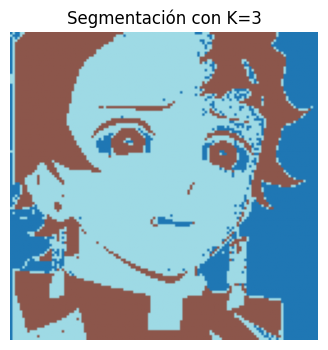

Procesando K=5...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


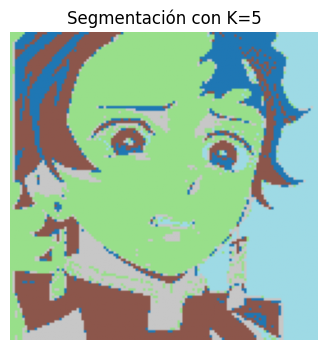

Procesando K=7...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


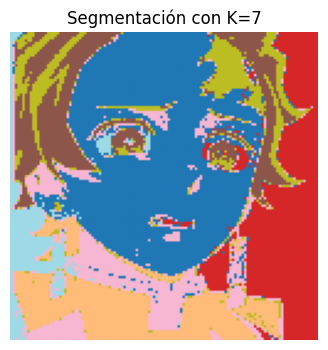

Procesando K=9...


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


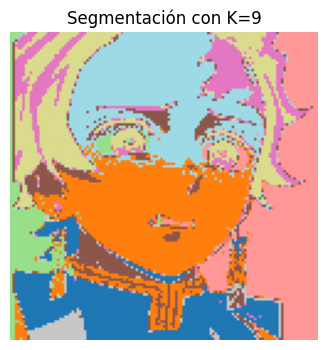

In [12]:
results = []

for k in [3, 5, 7, 9]:
    print(f"Procesando K={k}...")
    labels, inertia, sil_score = segment_image_with_kmeans(X_full, k)

    # Guardar resultados
    results.append((k, inertia, sil_score))

    # Visualización de segmentación
    segmented_img = labels.reshape(rows, cols)
    plt.figure(figsize=(4, 4))
    plt.imshow(segmented_img, cmap='tab20')
    plt.title(f"Segmentación con K={k}")
    plt.axis("off")
    plt.show()


## Reducción de dimensionalidad + clustering

Aqui se proyecta el conjunto de datos `[R, G, B, x, y]` a un espacio de **2 dimensiones** utilizando dos técnicas:

- **PCA**: proyección lineal que conserva la varianza global.
- **UMAP**: proyección no lineal que preserva la estructura local de los datos.

Luego, se aplica **KMeans** sobre los datos proyectados, y se comparan los resultados con los del espacio original.


In [13]:
from sklearn.decomposition import PCA

# Proyección a 2D con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full)

print("Forma del conjunto reducido con PCA:", X_pca.shape)


Forma del conjunto reducido con PCA: (15625, 2)


In [14]:
!pip install umap-learn --quiet

import umap

# Proyección a 2D con UMAP
umap_proj = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_proj.fit_transform(X_full)

print("Forma del conjunto reducido con UMAP:", X_umap.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Forma del conjunto reducido con UMAP: (15625, 2)



PCA:


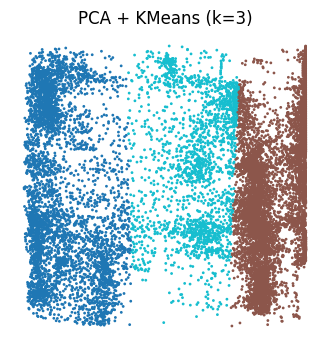

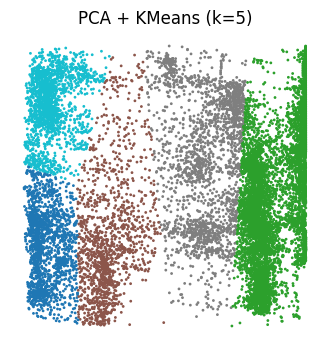

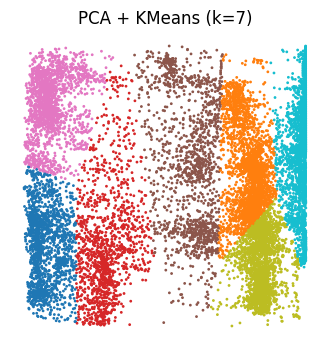

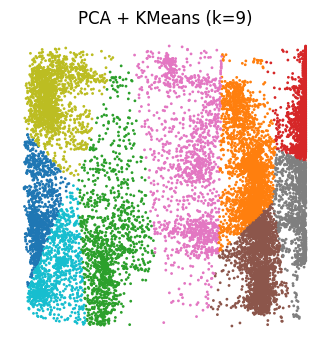


UMAP:


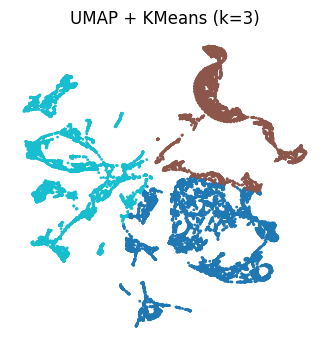

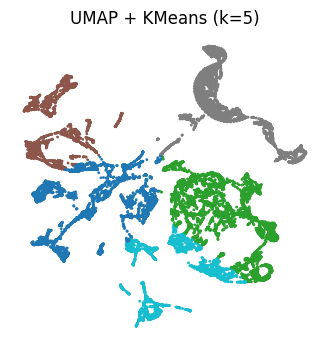

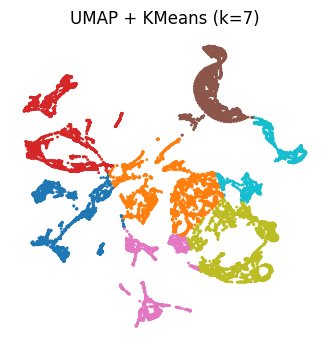

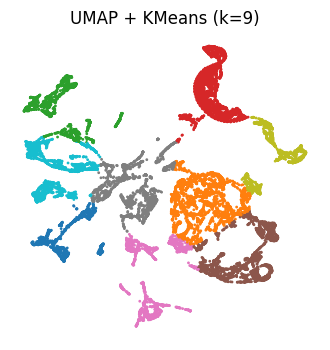

In [15]:
datasets = [("PCA", X_pca), ("UMAP", X_umap)]
results_proj = []

for name, X_proj in datasets:
    print(f"\n{name}:")
    for k in [3, 5, 7, 9]:
        labels, inertia, sil_score = segment_image_with_kmeans(X_proj, k, use_rapids=False)
        results_proj.append((name, k, inertia, sil_score))

        # Visualización directa del clustering en 2D
        plt.figure(figsize=(4, 4))
        plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='tab10', s=1)
        plt.title(f"{name} + KMeans (k={k})")
        plt.axis("off")
        plt.show()


In [17]:
import pandas as pd

df_proj = pd.DataFrame(results_proj, columns=["Proyección", "K", "Inercia", "Silueta"])
df_proj


,Proyección,K,Inercia,Silueta
0,PCA,3,4.615869e+07,0.540100
1,PCA,5,3.136456e+07,0.477318
2,PCA,7,1.532593e+07,0.470383
3,PCA,9,1.286874e+07,0.427665
4,UMAP,3,4.653707e+05,0.429900
5,UMAP,5,2.815265e+05,0.386139
6,UMAP,7,1.746352e+05,0.439703
7,UMAP,9,1.290244e+05,0.428719


## Análisis comparativo y conclusiones

### Análisis de resultados

Se evaluaron los resultados de segmentación de imagen a color con clustering KMeans aplicando dos técnicas de reducción de dimensionalidad: **PCA** (proyección lineal) y **UMAP** (proyección no lineal).

| Técnica | Mejor Silueta | K asociado |
|---------|----------------|------------|
| PCA     | **0.5401**     | 3          |
| UMAP    | 0.4391         | 7          |

### Observaciones clave

- **PCA mostró mejor desempeño en términos del índice de silueta**, especialmente con \(k = 3\). Esto sugiere una mayor cohesión y separación entre clusters en ese espacio reducido.
- **UMAP produjo menor inercia**, pero esta métrica no es comparable entre técnicas de proyección debido al cambio en escala del espacio.
- Visualmente, los clusters obtenidos con PCA tienden a ser más compactos y separados, mientras que UMAP preserva mejor la estructura local, pero puede dispersar grupos.

---

### Conclusión general

- La reducción de dimensionalidad **puede mejorar** o **facilitar** el clustering, dependiendo de la estructura de los datos.
- En este caso, **PCA entregó resultados más consistentes y visualmente claros** para segmentación en 2D.
- **UMAP sigue siendo útil** para detectar relaciones locales complejas, pero su interpretación requiere más precaución.

---

### Limitaciones del análisis

- No se cuenta con etiquetas reales para evaluar la segmentación con métricas externas como ARI o NMI.
- Solo se utilizó KMeans como método de clustering. Otros algoritmos como DBSCAN o GMM podrían ofrecer resultados complementarios.

---

### Recomendaciones posteriores

- Evaluar otras técnicas de clustering (como **HDBSCAN**, **GMM**, o **MeanShift**).
- Aplicar reducción de dimensión previa a clustering en conjuntos de datos más complejos (e.g., imágenes naturales, texturas).
- Comparar visualmente las segmentaciones proyectadas de vuelta al espacio imagen.
- Incluir métricas más robustas si se dispone de etiquetas reales o conocimiento experto.

---



> **Nombre:** Johan Steven Bejarano Muriel

> **Curso:** Teoria de prendizaje de Máquina (TAM)  
> **Fecha:** [08/06/2025]
